In [7]:
# Install packages
# !pip install prettytable

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
"""
# Normalizing Flows Implementation Guide

## Introduction
Normalizing flows are a class of generative models that learn complex probability distributions 
by transforming a simple base distribution through a sequence of invertible mappings.

## Key Concepts

### 1. Change of Variables Formula
The fundamental principle behind normalizing flows is the change of variables formula:
p_x(x) = p_z(z) * |det(dz/dx)|
where:
- p_x(x) is the target distribution
- p_z(z) is the base distribution (usually standard normal)
- |det(dz/dx)| is the absolute determinant of the Jacobian

### 2. Flow Types
Different flow architectures provide different ways to transform the data while maintaining
invertibility and tractable Jacobian determinants:
- Planar: Uses planar transformations (f(z) = z + u*h(w^T*z + b))
- Radial: Uses radial transformations around a learned reference point
- RealNVP: Uses affine coupling layers with masked transformations
- MAF: Uses autoregressive transformations for increased flexibility
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import Normal

import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import prettytable
from prettytable import PrettyTable
from prettytable import from_csv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error



In [53]:
# --- Step 1: Data Preparation ---
# Load data and compute log returns
data = pd.read_csv('raw (FX + EQ).csv')
log_returns = np.log(data / data.shift(1)).dropna()

# Preprocess the data
# Apply quantile transform
qt = QuantileTransformer(output_distribution='normal')
X_transformed = qt.fit_transform(log_returns.values)
X = torch.tensor(X_transformed, dtype=torch.float32)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (679). n_quantiles is set to n_samples.
  warnings.warn(


In [54]:
# --- Step 2: Flow Components ---
class Permute(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.register_buffer('perm', torch.randperm(dim))
        self.register_buffer('inv_perm', torch.argsort(self.perm))

    def forward(self, z):
        return z[:, self.perm], torch.zeros(z.size(0), device=z.device)

    def inverse(self, z):
        return z[:, self.inv_perm]

    def log_det_jacobian(self, z):
        return torch.zeros(z.size(0), device=z.device)



class RealNVPCoupling(nn.Module):
    """
    Real NVP coupling layer
    Reference: https://arxiv.org/abs/1605.08803
    """
    def __init__(self, dim, hidden_dim=64, mask_type='alternate'):
        super().__init__()
        self.dim = dim
        
        # Create mask
        self.mask = torch.ones(dim)
        if mask_type == 'alternate':
            self.mask[::2] = 0
        elif mask_type == 'half':
            self.mask[:dim//2] = 0
            
        # Scale and translation networks
        self.s_network = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()
        )
        
        self.t_network = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        
    def forward(self, z):
        masked_z = z * self.mask
        s = self.s_network(masked_z) * (1 - self.mask)
        t = self.t_network(masked_z) * (1 - self.mask)
        
        # Scale and shift
        exp_s = torch.exp(s)
        transformed = z * self.mask + (1 - self.mask) * (z * exp_s + t)
        log_det = torch.sum(s * (1 - self.mask), dim=1)
        
        return transformed, log_det

class RealNVPCoupling2(nn.Module):
    def __init__(self, dim, hidden_dim=64):
        super().__init__()
        self.dim = dim
        self.register_buffer('mask', (torch.arange(dim) % 2).float())

        self.s_net = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, dim), nn.Tanh()
        )

        self.t_net = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, z):
        mask = self.mask.to(z.device)
        z_masked = z * mask
        s = self.s_net(z_masked) * (1 - mask)
        t = self.t_net(z_masked) * (1 - mask)
        z_out = z_masked + (1 - mask) * (z * torch.exp(s) + t)
        log_det = torch.sum(s * (1 - mask), dim=1)
        return z_out, log_det

class MAF(nn.Module):
    """
    Masked Autoregressive Flow
    Reference: https://arxiv.org/abs/1705.07057
    """
    def __init__(self, dim, hidden_dim=64):
        super().__init__()
        self.dim = dim
        
        # Create MADE-like network
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * dim)  # Output both μ and log_σ
        )
        
        # Create autoregressive mask
        self.register_buffer('mask', self._create_mask())
        
    def _create_mask(self):
        # Create a lower triangular mask
        mask = torch.tril(torch.ones(self.dim, self.dim), -1)
        return mask
    
    def forward(self, z):
        batch_size = z.size(0)
        
        # Get parameters from network
        net_out = self.net(z)
        mu, log_sigma = net_out.chunk(2, dim=1)
        
        # Reshape mask for broadcasting
        mask = self.mask.unsqueeze(0)  # [1, dim, dim]
        
        # Apply mask to ensure autoregressive property
        # Compute masked mu: [batch_size, dim]
        masked_mu = torch.bmm(mask.expand(batch_size, -1, -1), 
                            z.unsqueeze(2)).squeeze(2)
        
        # Transform
        sigma = torch.exp(log_sigma)
        transformed = (z - masked_mu) / sigma
        log_det = -torch.sum(log_sigma, dim=1)
        
        return transformed, log_det

class MAF2(nn.Module):
    def __init__(self, dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 2 * dim)
        )

    def forward(self, z):
        out = self.net(z)
        mu, log_sigma = out.chunk(2, dim=1)
        log_sigma = torch.clamp(log_sigma, min=-5, max=5)  # Prevent NaNs
        z_trans = (z - mu) * torch.exp(-log_sigma)
        log_det = -log_sigma.sum(dim=1)
        return z_trans, log_det


In [55]:
# Define Full Normalizing Flow Model
class NormalizingFlow(nn.Module):
    """
    A sequence of normalizing flows with proper log determinant handling
    """
    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        
    def forward(self, z):
        log_det_sum = torch.zeros(z.size(0), device=z.device)
        
        for flow in self.flows:
            if isinstance(flow, (RealNVPCoupling, MAF)):
                z, log_det = flow(z)
            else:
                log_det = flow.log_det_jacobian(z)
                z = flow(z)
                
            # Ensure log_det has correct shape [batch_size]
            if log_det.dim() > 1:
                log_det = log_det.sum(1)
            elif log_det.dim() == 0:
                log_det = log_det.expand(z.size(0))
                
            log_det_sum += log_det
            
        return z, log_det_sum

# --- Step 3: Model Architecture ---
def build_flow(dim):
    layers = []
    for _ in range(4):
        layers.append(MAF2(dim))
        layers.append(Permute(dim))
        layers.append(RealNVPCoupling2(dim))
        layers.append(Permute(dim))
    return nn.ModuleList(layers)

class NormalizingFlow2(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers

    def forward(self, z):
        log_det = torch.zeros(z.size(0), device=z.device)
        for layer in self.layers:
            z, ld = layer(z)
            log_det += ld
        return z, log_det

In [56]:

# --- Step 4: Training Loop ---
def train_flow(flow, X, epochs=1000, batch_size=128, lr=1e-3):
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)
    loader = DataLoader(TensorDataset(X), batch_size=batch_size, shuffle=True)
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for (x_batch,) in loader:
            optimizer.zero_grad()
            z, log_det = flow(x_batch)
            prior = -0.5 * torch.sum(z ** 2, dim=1)
            loss = -(prior + log_det).mean()

            if torch.isnan(loss) or torch.isinf(loss):
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5.0)
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        losses.append(epoch_loss)
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")
    return losses


In [57]:
# Build and train the flow
flow_layers = build_flow(X.shape[1])
flow_model = NormalizingFlow2(flow_layers)
losses = train_flow(flow_model, X)


Epoch 0, Loss: 41.5772
Epoch 50, Loss: -290.5910
Epoch 100, Loss: -357.8079
Epoch 150, Loss: -405.2216
Epoch 200, Loss: -422.7293
Epoch 250, Loss: -464.1631
Epoch 300, Loss: -531.3175
Epoch 350, Loss: -595.9164
Epoch 400, Loss: -622.5252
Epoch 450, Loss: -646.5914
Epoch 500, Loss: -633.0147
Epoch 550, Loss: -673.3300
Epoch 600, Loss: -689.5331
Epoch 650, Loss: -732.7269
Epoch 700, Loss: -766.3026
Epoch 750, Loss: -740.8331
Epoch 800, Loss: -574.8920
Epoch 850, Loss: -752.1581
Epoch 900, Loss: -822.7142
Epoch 950, Loss: -856.8361


In [61]:
# --- Step 5: Generate Synthetic Returns ---
n_samples = len(X)
z = torch.randn(n_samples, X.shape[1])

with torch.no_grad():
    for flow in reversed(flow_model.layers):
        z, _ = flow(z)

synthetic_returns = z.numpy()
synthetic_df = pd.DataFrame(synthetic_returns, columns=log_returns.columns)
synthetic_df.to_csv('synthetic_returns.csv', index=False)

print("✅ Synthetic return series saved to 'synthetic_returns.csv'")


✅ Synthetic return series saved to 'synthetic_returns.csv'


C:\Users\dullz\AppData\Local\Temp\ipykernel_26512\2654328507.py:4: RuntimeWarning: overflow encountered in exp
  synthetic_prices = np.exp(np.cumsum(clipped_returns, axis=0)) * initial_prices


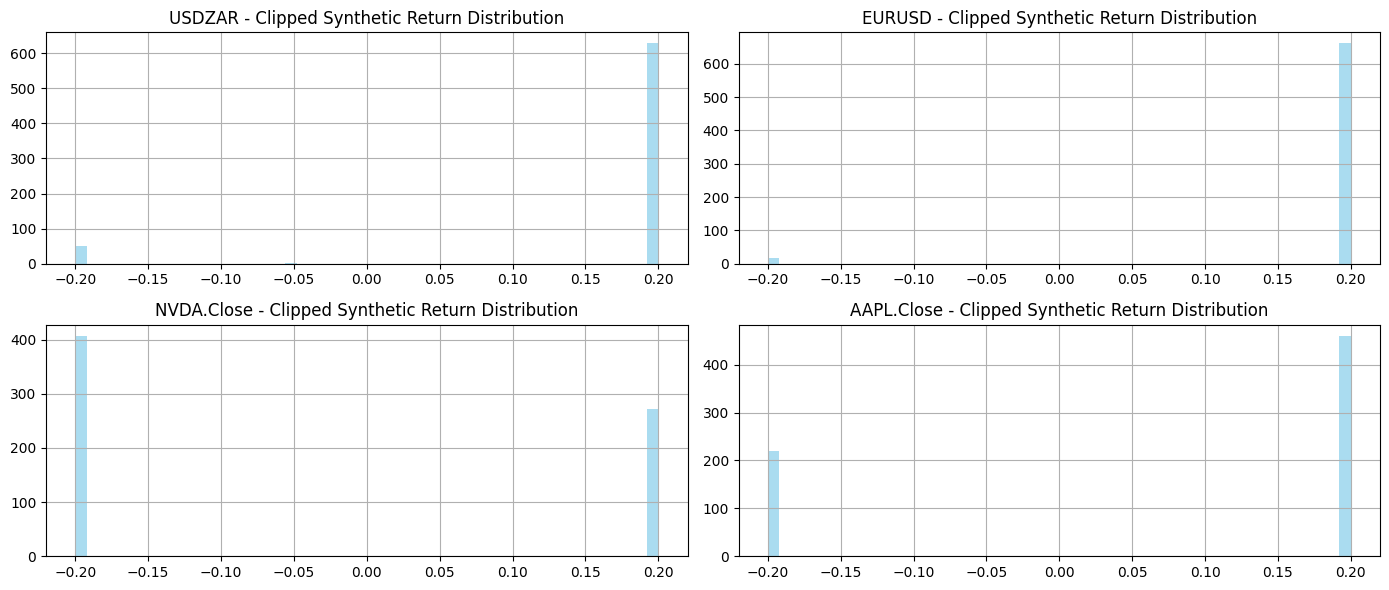

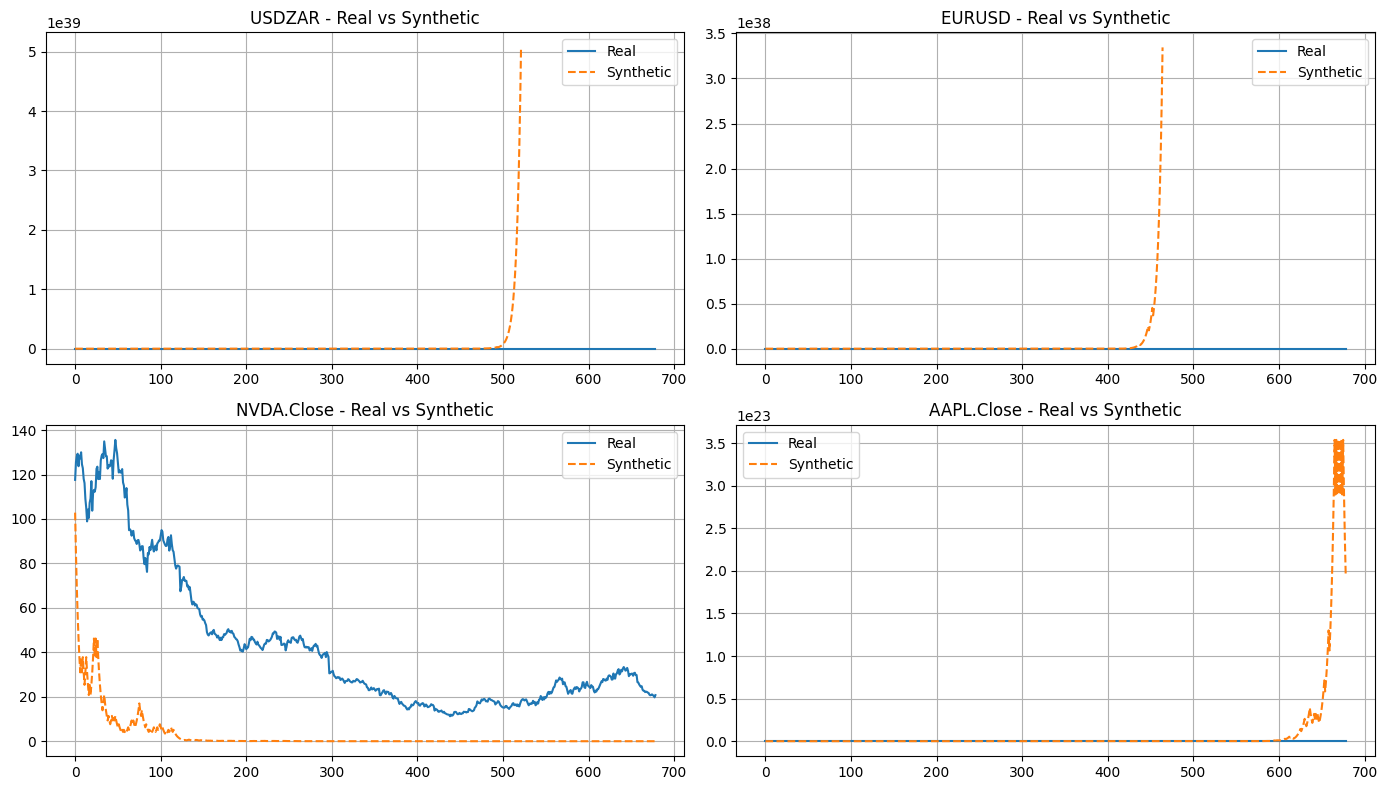


PCA Similarity: 0.3742
Correlation Similarity: 0.3150
Volatility MSE: 918620642989193.000000


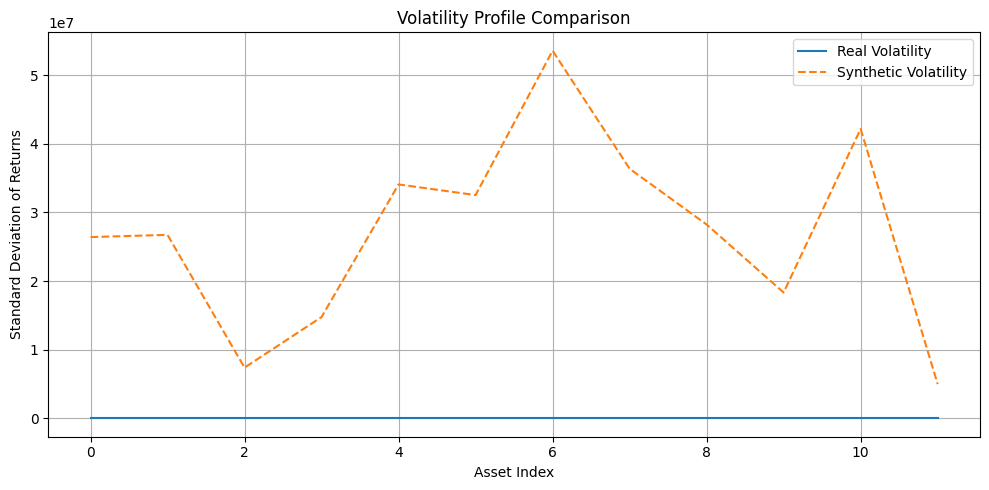

In [72]:
# --- Step 6: Convert to Synthetic Prices, Plot & Inspect Distribution ---
initial_prices = data.iloc[1].values
clipped_returns = np.clip(synthetic_df.values, -0.2, 0.2)
synthetic_prices = np.exp(np.cumsum(clipped_returns, axis=0)) * initial_prices
synthetic_prices_df = pd.DataFrame(synthetic_prices, columns=log_returns.columns)

# Plot distribution of clipped returns
plt.figure(figsize=(14, 6))
for i, asset in enumerate(assets_to_plot):
    plt.subplot(2, 2, i+1)
    plt.hist(clipped_returns[:, log_returns.columns.get_loc(asset)], bins=50, alpha=0.7, color='skyblue')
    plt.title(f"{asset} - Clipped Synthetic Return Distribution")
    plt.grid(True)
plt.tight_layout()
plt.show()

assets_to_plot = ["USDZAR", "EURUSD", "NVDA.Close", "AAPL.Close"]
plt.figure(figsize=(14, 8))
for i, asset in enumerate(assets_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.plot(data[asset].values[:len(synthetic_prices)], label='Real', linewidth=1.5)
    plt.plot(synthetic_prices_df[asset], label='Synthetic', linestyle='--')
    plt.title(f"{asset} - Real vs Synthetic")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 7: Evaluation Metrics ---
def pca_similarity(real, synthetic, n_components=3):
    pca_real = PCA(n_components=n_components).fit(real)
    pca_synth = PCA(n_components=n_components).fit(synthetic)
    return np.abs(np.dot(pca_real.components_, pca_synth.components_.T)).sum(axis=1).mean()

def correlation_similarity(real, synthetic):
    corr_real = np.corrcoef(real.T)
    corr_synth = np.corrcoef(synthetic.T)
    return np.corrcoef(corr_real.flatten(), corr_synth.flatten())[0, 1]

def volatility_profile(real, synthetic):
    vol_real = np.std(real, axis=0)
    vol_synth = np.std(synthetic, axis=0)
    return mean_squared_error(vol_real, vol_synth), vol_real, vol_synth

pca_sim = pca_similarity(log_returns.values, synthetic_df.values)
corr_sim = correlation_similarity(log_returns.values, synthetic_df.values)
vol_mse, vol_real, vol_synth = volatility_profile(log_returns.values, synthetic_df.values)

print(f"\nPCA Similarity: {pca_sim:.4f}")
print(f"Correlation Similarity: {corr_sim:.4f}")
print(f"Volatility MSE: {vol_mse:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(vol_real, label='Real Volatility')
plt.plot(vol_synth, label='Synthetic Volatility', linestyle='--')
plt.title("Volatility Profile Comparison")
plt.xlabel("Asset Index")
plt.ylabel("Standard Deviation of Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [70]:
print(synthetic_prices_df)

        USDZAR     GBPZAR     EURZAR     GBPCNY    EURUSD    GBPUSD  \
0    21.649608  19.126286  23.994213  11.398375  1.354291  1.611336   
1    26.442890  15.659279  19.644800  13.922006  1.654135  1.968090   
2    32.297422  12.820733  23.994213  11.398375  2.020365  2.403830   
3    39.448161  10.496728  29.306596   9.332200  2.467680  2.936045   
4    48.182092   8.593994  35.795161   7.640559  3.014031  3.586094   
..         ...        ...        ...        ...       ...       ...   
674        inf   0.000000        inf   0.026366       inf       inf   
675        inf   0.000000        inf   0.021587       inf       inf   
676        inf   0.000000        inf   0.026366       inf       inf   
677        inf   0.000000        inf   0.032203       inf       inf   
678        inf   0.000000        inf   0.039333       inf       inf   

       NVDA.Close    AAPL.Close    AMZN.Close     DJT.Close  PDCO.Close  \
0    9.627454e+01  2.806661e+02  1.409199e+02  2.423263e+01   27.444919 

In [6]:
def visualize_flow(flow, data, n_samples=1000):
    """
    Create comprehensive visualizations of the flow with improved numerical stability
    """
    with torch.no_grad():
        # Generate samples
        z = torch.randn(n_samples, 2)
        samples, _ = flow(z)
        
        # Clip extreme values
        samples = torch.clamp(samples, -10, 10)
        
        samples = samples.numpy()
        z = z.numpy()
        data = data.numpy()
    
    # Function to safely compute histogram
    def safe_histogram2d(x, y, bins=50):
        # Remove any infinite or NaN values
        mask = np.isfinite(x) & np.isfinite(y)
        x = x[mask]
        y = y[mask]
        
        # Compute reasonable bounds
        x_min, x_max = np.percentile(x, [1, 99])
        y_min, y_max = np.percentile(y, [1, 99])
        
        range_tuple = [[x_min, x_max], [y_min, y_max]]
        return np.histogram2d(x, y, bins=bins, range=range_tuple, density=True)
    
    fig = plt.figure(figsize=(15, 10))
    
    # Original distribution
    plt.subplot(231)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = safe_histogram2d(data[:, 0], data[:, 1])
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Original Distribution')
    
    # Base distribution
    plt.subplot(232)
    plt.scatter(z[:, 0], z[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = safe_histogram2d(z[:, 0], z[:, 1])
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Base Distribution (Normal)')
    
    # Generated distribution
    plt.subplot(233)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = safe_histogram2d(samples[:, 0], samples[:, 1])
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Generated Distribution')
    
    # Histograms with safe ranges
    plt.subplot(234)
    h, xedges, yedges = safe_histogram2d(data[:, 0], data[:, 1])
    plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Original Distribution (2D Histogram)')
    
    plt.subplot(235)
    h, xedges, yedges = safe_histogram2d(z[:, 0], z[:, 1])
    plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Base Distribution (2D Histogram)')
    
    plt.subplot(236)
    h, xedges, yedges = safe_histogram2d(samples[:, 0], samples[:, 1])
    plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Generated Distribution (2D Histogram)')
    
    plt.tight_layout()
    return fig

def train_flow(flow, data, n_epochs=1000, lr=1e-4):
    """
    Train the normalizing flow with improved numerical stability
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    losses = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        try:
            # Forward pass through flow
            z, log_det = flow(data)
            
            # Clip extreme values
            z = torch.clamp(z, -10, 10)
            log_det = torch.clamp(log_det, -100, 100)
            
            # Compute loss (negative log likelihood)
            prior_ll = -0.5 * (z**2).sum(1) - 0.5 * np.log(2*np.pi) * z.shape[1]
            loss = -(prior_ll + log_det).mean()
            
            # Check for invalid values
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Invalid loss value at epoch {epoch+1}")
                continue
            
            # Clip loss for stability
            loss = torch.clamp(loss, -1e6, 1e6)
            
            # Backward pass
            loss.backward()
            
            # Clip gradients for stability
            torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Add parameter constraints after optimization step
            with torch.no_grad():
                for param in flow.parameters():
                    param.data.clamp_(-10, 10)
            
            losses.append(loss.item())
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')
                
        except RuntimeError as e:
            print(f"Error at epoch {epoch+1}: {str(e)}")
            continue
    
    return flow, losses

In [11]:
def main():
    # Generate toy datasets
    datasets = {
        'two_gaussians': create_toy_dataset(1000, 'two_gaussians'),
        'circles': create_toy_dataset(1000, 'circles'),
        'moons': create_toy_dataset(1000, 'moons')
    }
    
    # Create different flow models
    dim = 2
    flow_architectures = {
        'Simple': [
            PlanarFlow(dim),
            RadialFlow(dim),
            PlanarFlow(dim)
        ],
        'RealNVP': [
            RealNVPCoupling(dim),
            RealNVPCoupling(dim, mask_type='alternate'),
            RealNVPCoupling(dim, mask_type='half')
        ],
        'MAF': [
            MAF(dim),
            MAF(dim),
            MAF(dim)
        ],
        'Mixed': [
            PlanarFlow(dim),
            RealNVPCoupling(dim),
            MAF(dim)
        ]
    }
    
    # Train and visualize each combination
    for dataset_name, data in datasets.items():
        print(f"\nTraining on {dataset_name} dataset:")
        for arch_name, flows in flow_architectures.items():
            print(f"\nTraining {arch_name} architecture...")
            
            # Initialize flow model
            flow_model = NormalizingFlow(flows)
            
            # Train with lower learning rate for stability
            trained_flow, losses = train_flow(flow_model, data, n_epochs=3000, lr=1e-4)
            
            # Visualize
            fig = visualize_flow(trained_flow, data)
            plt.suptitle(f'{dataset_name} with {arch_name} Flow')
            plt.show()
            
            # Plot loss curve
            plt.figure(figsize=(8, 4))
            plt.plot(losses)
            plt.title(f'Training Loss: {dataset_name} with {arch_name} Flow')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.yscale('log')
            plt.show()

# if __name__ == "__main__":
#     main()